<a href="https://colab.research.google.com/github/WuzI38/Data/blob/main/Eldritch_Evolution_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The final version of eldritch evolution
Good parts only + new mutation + new way of choosing specimens to reproduce

## Basic parameters

In [ ]:
MUTATION_RATE = 0.9 # Probability of mutation
MUTATION_DROP_RATE = 650 # Muation is reduced for generations 100, 200, 300... 
MUTATION_SWAPS = 15 # The amount of swaps applied to specimen if mutation is applied
MUTATION_REDUCTION = 0.2 # This number if subtracted from MUTATION_RATE every MUTATION_DROP_RATE generations
MUTATION_SWAPS_REDUCTION = 0 # This number is subtracted from MUTATION_SWAPS every MUTATION_DROP_RATE generations
GENERATIONS = 3000 # Number of generations
SPECIMEN_GENERATION_METHOD = 0 # 0 for taking each segment separately, 1 for taking the first half of segments from the same specimen
BREEDING_POOL_SELECTION = 0 # 0 for tournament and 1 for fitness based roulette 
FAVOUR_THE_BEST_ONLY = True # If roulette method is chosen greatly increases the chance of best specimen beeing chosen
BEST_ONLY_MODIFIER = 0.9 # Slightly reduces (if < 1, cannot be > 1) the probability of the best one being chosen
TOURNAMENT_K = 2 # Number of specimens chosen for each duel in tournament method

# DO NOT CHANGE PARAMETERS BELOW AFTER GENERATING THE INITIAL POOL OF SPECIMENS!!!

# Benchmark constants
USE_BENCHMARK = False # Should benchmark be used
PATH = "/content/m25.txt" # Path to the downloaded benchmark data
PROCESSORS = 0 # The initial amount of processors
INIT_TASKS = 0 # The initial amount of task
MAX_TASK_SIZE = 0 # Max len of a single task
TASKS_LEN = INIT_TASKS + PROCESSORS # After benchmark generation 1 task is added to each of the processors
# TASKS = None # Calculated after benchmark creation

# Specimen generation constants
POPULATION_SIZE = 20 # Initial size of poplation

## Getting data

### Benchmark generation

In [ ]:
import numpy as np
from random import randint

if USE_BENCHMARK:
  tasks = np.random.randint(MAX_TASK_SIZE, size=INIT_TASKS) + 1
  proc_order = np.empty([INIT_TASKS])
  greedy = np.array([0 for _ in range(PROCESSORS)])

  for task_index, task in enumerate(tasks):
    index_min = np.argmin(greedy)
    greedy[index_min] += task
    proc_order[task_index] = index_min

  spec = np.column_stack((tasks, proc_order))
  lens = np.empty([PROCESSORS])
  for proc in range(PROCESSORS):
    sum_len = spec[spec[:, 1] == proc]
    sum_len = np.sum(sum_len[:, 0]).astype(int)
    lens[proc] = sum_len

  max_value = max(lens)
  max_value_index = np.argmax(lens)
  rand = randint(1, 10)

  additional = np.empty(PROCESSORS)

  for x in range(PROCESSORS):
    additional[x] = max_value + rand - lens[x]

  final = np.concatenate((spec[:, 0], additional), axis=None)

  TASKS = final
  print(np.sort(final))
  print(f"Optimal solution: {sum(TASKS)/PROCESSORS}")

### Data from file

In [ ]:
if not USE_BENCHMARK:
  arr = []

  with open(PATH) as file:
    for index, value in enumerate(file):
      if index == 0: # First number is the amount of processors
        PROCESSORS = int(value)
      if index == 1:
        TASKS_LEN = int(value) # Number of tasks
      if index > 1:
        arr.append(int(value)) # The numbers represent the length of particular tasks

  TASKS = np.array(arr) 
  print(TASKS, TASKS_LEN, PROCESSORS, np.max(TASKS))
  print(np.sum(TASKS))

[ 157  462  779    6   98  316  450  901  372  941   94  366  781   23
   16  200  686   45  311  744  784  842  168  467  214  547   74   14
  499  283  981  822  621  140  895  364  185  128  794   18  646  260
  419  751  532  743  923  490  478  527  543   60  915  359   90   28
   44  907   18  484  718   17  820  592   11  431  657  428  373    3
   58  618    7   60  980  508  813   15  568  832  625  300    2   29
    6   11    8  198  701  150  500  480  478  878  380  193  367  971
  276  846  590  923  961  777  241   16   91    6  419  403  456  982
   41  557  204  374  908   45  686   37  681  576  133   16  420  749
  454  597  820  279  571  606  461  271  614  933 1000    2  461   16
  171  478   92  225   39  899  405  670  581  833  867  880  874  838
  246    1  563   23  280  762  211  836   25  439  858    1  368    1
  932  945  917  873  100   41  357  373  509  871  386  976   96  272
  417  303  334   14  576   99  781  494  159  833  555  502  943  144
   10 

## Creation of the initial pool of specimens

In [ ]:
# Create empty specimen list
specimens = np.empty([POPULATION_SIZE, TASKS_LEN, 2])

### Applying greedy initialization

In [ ]:
def random_greedy_init(specimens, tasks=TASKS, tasks_len=TASKS_LEN, processors=PROCESSORS, pop_size=POPULATION_SIZE):
  tasks_shuffled = np.copy(tasks)
  proc_order = np.empty([tasks_len])
  np.random.shuffle(tasks_shuffled)
  greedy = np.array([0 for _ in range(processors)])

  for i in range(pop_size):
    for task_index, task in enumerate(tasks_shuffled):
      index_min = np.argmin(greedy)
      greedy[index_min] += task
      proc_order[task_index] = index_min
    
    spec = np.column_stack((tasks_shuffled, proc_order))
    spec = spec[np.argsort(spec[:, 0])]
    specimens[i, :, :] = spec
    np.random.shuffle(tasks_shuffled)

In [ ]:
random_greedy_init(specimens)
specimens[0][:5]

array([[ 1.,  6.],
       [ 1., 19.],
       [ 1.,  8.],
       [ 2., 16.],
       [ 2.,  4.]])

### Visualize particular specimens

In [ ]:
# Create function to plot the best specimen
import pandas as pd
import matplotlib.pyplot as plt

def plot_results(specimen, processors=PROCESSORS):
  processors = dict(zip([f"Processor {x}" for x in range(PROCESSORS)], [0 for _ in range(PROCESSORS)]))
  proc_df = pd.Series(processors).to_frame("time")
  
  for task in specimen:
    proc_df.loc[f"Processor {task[1].astype(int)}"] += task[0]

  proc_df.plot.bar(figsize=(10, 7))
  plt.title(f"Max time value: {proc_df.max()['time']}")
  plt.show()

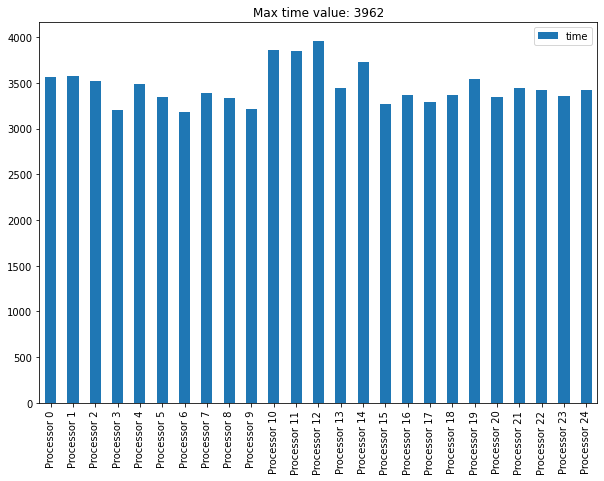

In [ ]:
# Plot greedy solution for specimen 0
plot_results(specimens[0])

## Offspring creation, mutation, fitness calculation

### Offspring creation
```generate_offspring``` is a function that takes segments one by one with probability of taking the segment from first specimen equal to 50%

```generate_offspring_2``` combines first half of one of the specimens with second half of the other

In [ ]:
def generate_offspring(parent_a, parent_b, tasks_len=TASKS_LEN):
  '''
    This thing randomly chooses (50% probability) a task assigned to certain processor
    from one of the parents and passes it to the baby
  '''
  choice = np.random.randint(2, size=tasks_len).astype(bool)
  choice2d = np.column_stack((choice, choice))
  mix = np.where(choice2d, parent_a, parent_b)
  return mix

generate_offspring(specimens[0], specimens[1])[:5, :]

array([[ 1.,  6.],
       [ 1., 19.],
       [ 1.,  5.],
       [ 2., 16.],
       [ 2.,  4.]])

In [ ]:
def generate_offspring_2(parent_a, parent_b, tasks_len=TASKS_LEN):
  '''
    This thing takes half of parent_a and joins it with half of parent_b
  '''
  div = len(parent_a) // 2
  choice = np.random.randint(2)
  if(choice):
    offspring = np.concatenate((parent_a[:div], parent_b[div:]), axis=0)
  else:
    offspring = np.concatenate((parent_b[:div], parent_a[div:]), axis=0)
  return offspring

generate_offspring_2(specimens[0], specimens[1])[:5, :]

array([[ 1.,  5.],
       [ 1., 22.],
       [ 1.,  5.],
       [ 2.,  3.],
       [ 2., 20.]])

### Calculate fitness for a single specimen

In [ ]:
def calculate_fitness(specimen, tasks_len=TASKS_LEN):
  '''
    Calculate length value of certain specimen (max time for single processor)
  '''
  lens = np.zeros(tasks_len)
  for x in range(tasks_len):
    lens[specimen[x, 1].astype(int)] += specimen[x, 0] # Why this is not an int? No idea
  return np.amax(lens)

# This value is also visible on the graph above
print(calculate_fitness(specimens[0]))

3962.0


### New version of mutation tries to fix the specimen by moving tasks from the most to least busy processors

In [ ]:
def mutate(specimen, swaps=MUTATION_SWAPS, tasks_len=TASKS_LEN, processors=PROCESSORS):
  # Very simmilar to calculate_fitness
  max_tasks = np.zeros(processors)
  for index, value in enumerate(specimen):
    max_tasks[value[1].astype(int)] += value[0]

  specimen_cp = np.copy(specimen)  

  for _ in range(swaps):
    # Find indices of most and least busy processors
    max_len = np.amax(max_tasks)
    min_len = np.amin(max_tasks)

    # Find indices of tasks performed by most and least busy processors
    max_index = np.where(max_tasks == max_len)[0][0]
    min_index = np.where(max_tasks == min_len)[0][0]

    # Find task performed by most busy processor with min len
    elems_of_max_processor = specimen_cp[np.where(specimen_cp[:, 1] == max_index)]
    min_elem_of_max_processor = np.min(elems_of_max_processor[:, 0]).astype(int)

    # Check if moving the task to least busy processor would increase performance. If so make a swap
    max_tasks_temp = np.copy(max_tasks)
    max_tasks_temp[max_index] -= min_elem_of_max_processor
    max_tasks_temp[min_index] += min_elem_of_max_processor
    if np.amax(elems_of_max_processor) <= max_len:
      # Make a swap
      max_tasks[max_index] -= min_elem_of_max_processor
      max_tasks[min_index] += min_elem_of_max_processor
      swap_index = np.where((specimen_cp[:, 0] == min_elem_of_max_processor) & (specimen_cp[:, 1] == max_index))
      specimen_cp[swap_index, 1] = min_index
  return specimen_cp
      
scp = mutate(specimens[0])

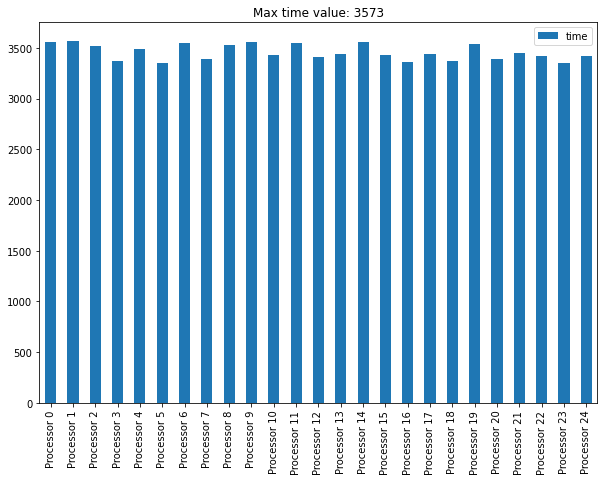

In [ ]:
# Plot greedy solution for specimen 0
plot_results(scp)

### Fitness calculation for all of the specimens

In [ ]:
# Returns calculated lenghts of all specimens as np array
def calculate_lenghts(specimens):
  return np.array(list(map(calculate_fitness, specimens)))

lens = calculate_lenghts(specimens)
print(lens, np.min(lens))

[3962. 3828. 3906. 3933. 4121. 3855. 4078. 4215. 4133. 4295. 4313. 4140.
 4291. 4216. 4104. 4128. 4144. 4214. 3974. 4053.] 3828.0


## Choosing specimens for reproduction

### Tournament method

In [ ]:
def tournament_generation(specimens, pop_size=POPULATION_SIZE, k=TOURNAMENT_K):
  if k > pop_size:
    return
  tournament_winners = np.empty((pop_size * 2))
  indices = np.array(range(pop_size))
  specimens_mapped = calculate_lenghts(specimens)
  for index in range(pop_size * 2):
    repeat = True
    while repeat:
      np.random.shuffle(indices)
      winner = np.min(specimens_mapped[indices[:k]])
      winner_index = np.where(specimens_mapped[indices[:k]] == winner)[0][0]
      tournament_winners[index] = indices[winner_index]
      repeat = (index % 2 == 1 and tournament_winners[index] == tournament_winners[index - 1])
  return tournament_winners.reshape((pop_size, 2)).astype(int)

tournament_generation(specimens)[:5]

array([[ 4,  5],
       [11,  8],
       [ 8, 19],
       [ 8,  1],
       [ 3, 16]])

In [ ]:
def create_fitness_array(specimens, favour_the_best=False, modifier=BEST_ONLY_MODIFIER):
  '''
    Calculate inverse probability values for each specimen
  '''
  specimens_mapped = calculate_lenghts(specimens) # Calculate lengths of all specimens
  if favour_the_best:
    specimens_mapped -= (np.min(specimens_mapped) * modifier - 1)
  weights = np.reciprocal(specimens_mapped) # invert weights
  weights = weights / np.sum(weights) # normalize
  return weights # Return the probability for each specimen (greater len -> lesser probability)

fit_arr = create_fitness_array(specimens, False)
print(fit_arr)
print(f"Max value of fitness: {np.max(fit_arr)}\nMin value of fitness: {np.min(fit_arr)}")

[0.05161767 0.05342455 0.0523577  0.05199827 0.04962611 0.05305037
 0.05014938 0.04851938 0.04948202 0.04761564 0.04741692 0.04939836
 0.04766003 0.04850787 0.04983167 0.04954196 0.04935067 0.04853089
 0.0514618  0.05045872]
Max value of fitness: 0.053424553409087534
Min value of fitness: 0.047416923359607475


In [ ]:
def roulette_generation(fitness_array, pop_size=POPULATION_SIZE):
  options = np.array(range(pop_size))
  parents = np.empty([pop_size, 2])
  for index in range(pop_size):
    index_a = np.random.choice(options, p=fitness_array)
    index_b = np.random.choice(options, p=fitness_array)
    # Do not allow one parent to breed with itself - if same index was chosen twice swap second index with a random index
    if index_a == index_b:
      options_cp = np.append(options[:index_a], options[index_a+1:])
      index_b = np.random.choice(options_cp)
    parents[index] = np.array([index_a, index_b])
  return parents.astype(int)

roulette_generation(fit_arr)[:5]

array([[ 4, 12],
       [16, 17],
       [10, 18],
       [18,  0],
       [ 7, 11]])

## Simulation

### Save generated specimens for further tests

In [ ]:
"""try: 
  specimens_copy
except NameError:
  specimens_copy = np.copy(specimens)
else:
  specimens = np.copy(specimens_copy)"""

'try: \n  specimens_copy\nexcept NameError:\n  specimens_copy = np.copy(specimens)\nelse:\n  specimens = np.copy(specimens_copy)'

In [ ]:
# specimens_copy = specimens

### Main algorithm

In [ ]:
from random import random

# Save the best specimen for every generation
lenghts_best_of_gen = np.empty([GENERATIONS])
best_of_gen = np.empty([GENERATIONS, TASKS_LEN, 2])

# Save best 
best_specimens_set = np.empty([POPULATION_SIZE, TASKS_LEN, 2])
best_set_shortest_specimen = calculate_fitness(specimens[0])

# Simulate X generations (by default X = 20)
for gen_num in range(GENERATIONS): 
  # Save shortest generated specimen
  specimens_lenghts = calculate_lenghts(specimens) # Calculate all lens
  shortest_specimen_len = np.min(specimens_lenghts) # Find the shortest specimen's len
  shortest_specimen = np.copy(specimens[np.where(specimens_lenghts == shortest_specimen_len)]) # Save the shortest specimen
  lenghts_best_of_gen[gen_num] = shortest_specimen_len
  best_of_gen[gen_num] = shortest_specimen[0]

  if shortest_specimen_len < best_set_shortest_specimen:
    best_set_shortest_specimen = shortest_specimen_len
    best_specimens_set = np.copy(specimens)
  
  specimens_new = np.empty([POPULATION_SIZE, TASKS_LEN, 2]) # Create new population

  if not BREEDING_POOL_SELECTION: # tournament_selection
    parents = tournament_generation(specimens, k=TOURNAMENT_K)
  else:
    fit_arr = create_fitness_array(specimens, FAVOUR_THE_BEST_ONLY, BEST_ONLY_MODIFIER)
    parets = roulette_generation(fit_arr)

  for i in range(POPULATION_SIZE): # Create a new set of babies (size = POPULATION_SIZE)
    parent_a = specimens[parents[i, 0]]
    parent_b = specimens[parents[i, 1]]

    # Create a new specimen
    if not SPECIMEN_GENERATION_METHOD:
      new_specimen = generate_offspring(parent_a, parent_b)
    else:
      new_specimen = generate_offspring_2(parent_a, parent_b)

    # Apply mutation
    if random() <= MUTATION_RATE:
      new_specimen = mutate(new_specimen)

    specimens_new[i, :, :] = new_specimen # Add new specimens to next generation

  specimens = np.copy(specimens_new)
  if len(set(calculate_lenghts(specimens))) == 1:
    specimens = np.copy(best_specimens_set)

  # Decrease mutation rate by MUTATION_REDUCTION every MUTATION_DROP_RATE iterations
  if MUTATION_DROP_RATE >= 1:
    if gen_num % MUTATION_DROP_RATE == 0 and gen_num:
      MUTATION_RATE -= MUTATION_REDUCTION

## Analysing the results

In [ ]:
# Check the improvement over generations
lenghts_best_of_gen, np.min(lenghts_best_of_gen)

(array([3828., 4097., 4240., ..., 3465., 3466., 3462.]), 3460.0)

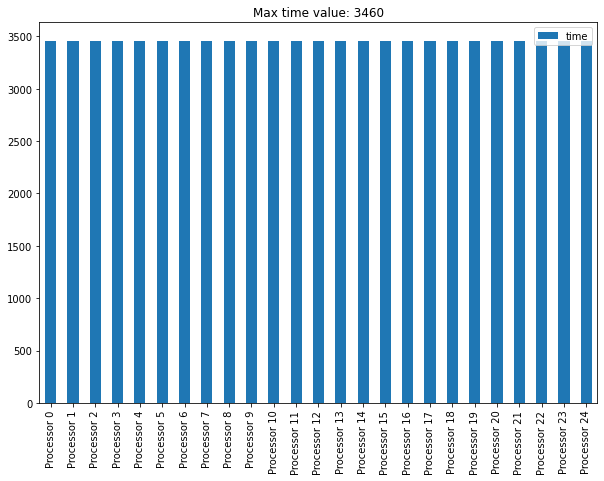

In [ ]:
# Plot best specimen
best_specimen = best_of_gen[np.where(lenghts_best_of_gen == np.min(lenghts_best_of_gen))][0]
plot_results(best_specimen)

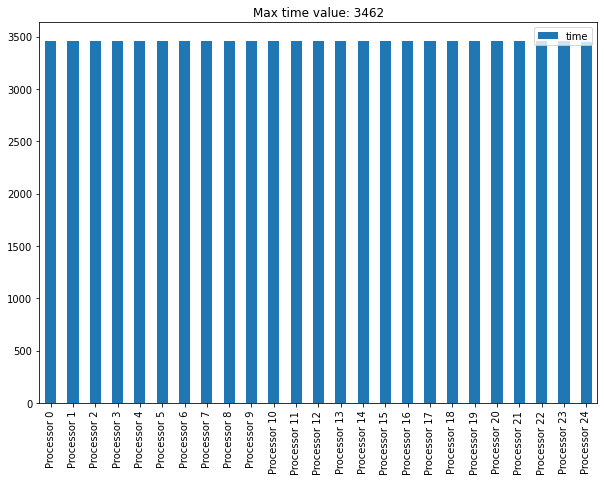

In [ ]:
# Plot the last
last_specimen = best_of_gen[-1]
plot_results(last_specimen)

In [ ]:
fit_arr = create_fitness_array(specimens) # Check if local minimum was achieved
fit_arr = set(fit_arr)
fit_arr

{0.04955289359150999,
 0.04968027892207942,
 0.049808320878064166,
 0.04985114832507884,
 0.049865440512098645,
 0.04998007370867818,
 0.049994439927048016,
 0.05002319715450102,
 0.05005198748379858,
 0.050066395079504916,
 0.05008081097212786,
 0.050095235168836426,
 0.050109667676807856,
 0.05012410850322769,
 0.05013855765528973,
 0.0501530151401961}